In order to decrease the size of the passed images (2048x2048) I will chunk them and generate dataset at 1024x1024 and 512x512

## Imports

### Imports from mask_crnn

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = os.getcwd()
print(ROOT_DIR)
if ROOT_DIR.endswith("/code/training"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

ROOT_DIR = "/home/max/Project_mrcnn"
print(ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log


import tensorflow as tf

# import nucleus

/home/max/bb2899/code
/home/max/Project_mrcnn


/home/max/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Imports I added

In [2]:
%matplotlib inline
import requests
import skimage
from matplotlib import pyplot as plt
import pickle
import glob

## Classes

In [3]:
class NucleiConfig(Config):
    """Configuration for training on the nucleus segmentation dataset."""
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Define the number of GPU to use
    GPU_COUNT = 1
    
    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + nuclei + undefined + clusters

    # Number of training and validation steps per epoch
#     STEPS_PER_EPOCH = (300 // IMAGES_PER_GPU)
#     VALIDATION_STEPS = max(1, 300 // IMAGES_PER_GPU)

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nucleus and BG
    DETECTION_MIN_CONFIDENCE = 0

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet101"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 1024
    IMAGE_MIN_SCALE = 0.5

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (16, 32, 64, 128,526)

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    # TODO: check if it needs to be RGB 
    MEAN_PIXEL = np.array([43.53, 39.56, 48.22])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 200

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 400


class NucleiInferenceConfig(NucleiConfig):
    # Set batch size to 1 to run one image at a time
    
    # GPU_COUNT has to be one no????
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Don't resize imager for inferencing
    IMAGE_RESIZE_MODE = "pad64"
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7

In [4]:
class NucleiDataset(utils.Dataset):    
    
    def add_segmentation_classes(self,labels_dict):
        """
        add the classes to the dataset according to the labels
        used for segmentation
        
        labels_dict: dictionary with labels and corresponding int
    
        """
        # Start class labelling from 1 because 0 is for the background
        
        for lab, lab_idx in labels_dict.items():
            self.add_class(lab,lab_idx,lab)
            
    
    def load_nuclei(self, dataset_dir, subset_dir):
        """Load a subset of the nuclei dataset.

        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
   
        
        dataset_dir = os.path.join(dataset_dir, subset_dir)        
        
        # Get image ids from names of files
        
        image_paths = glob.glob(dataset_dir+'*.npy')
        
        for image_path in image_paths:
            
            # Define the image path
            image_id = image_path.split('/')[-1]
            
            # Determine the size of the image
            image = np.load(image_path)
            image = skimage.util.img_as_ubyte(image)
            image = skimage.color.grey2rgb(image)
            height, width = image.shape[:2]
        
            # Add image
            self.add_image(
                "nuclei",
                image_id=image_id,
                path=image_path,
                width=width, height=height)
            
            
    def load_nuclei_validation(self, dataset_dir, subset_dir):
        """Load a subset of the nuclei dataset.

        dataset_dir: Root directory of the dataset
        subset: Subset to load. Either the name of the sub-directory,
                such as stage1_train, stage1_test, ...etc. or, one of:
                * train: stage1_train excluding validation images
                * val: validation images from VAL_IMAGE_IDS
        """
   
        
        files_dir = os.path.join(dataset_dir, subset_dir)        
        
        for image_id in next(os.walk(files_dir))[2]:
            if not image_id[0:2]=='._':

                # Define the image path
                image_path = files_dir+image_id

                # Determine the size of the image
                image = skimage.io.imread(image_path)
                image = skimage.util.img_as_ubyte(image)
                image = skimage.color.grey2rgb(image)
                height, width = image.shape[:2]

                # Add image
                self.add_image(
                    "nuclei",
                    image_id=image_id,
                    path=image_path,
                    width=width, height=height)  
            
    
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        

        image_info = self.image_info[image_id]
        
        # Load mask
        image_path = image_info['path']
        mask = np.load(image_path)
        mask = mask[:,:,1:]
        
        class_ids = np.amax(mask,axis=(0,1)).astype(np.int32)
        
        return mask, class_ids

    
    
    
    
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        
        image_info = self.image_info[image_id]
        image_path = image_info['path']
        image = np.load(image_path)
        image = image[:,:,0]
        image = skimage.color.grey2rgb(image)
        return image
    
    
    def load_image_png(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        
        image_info = self.image_info[image_id]
        image_path = image_info['path']
        image = skimage.io.imread(image_path)
        image = skimage.img_as_ubyte(image)
        image = skimage.color.grey2rgb(image)
        return image
    
    
    def plot_masks(self,image, image_id, mask, class_ids):
        unique_class_ids = np.unique(class_ids)
        fig, axarr = plt.subplots(1,len(unique_class_ids)+1)
        fig.set_size_inches((8,5))
        axarr[0].axis('off')
        axarr[0].imshow(image)
        axarr[0].set_title(self.image_info[image_id]['id'])

        for idx,class_id in enumerate(unique_class_ids):
            # Pull all the labels together
            m = mask[:, :, np.where(class_ids == class_id)[0]]
            m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
            axarr[idx+1].axis('off')
            axarr[idx+1].imshow(m)
            
            lab = self.class_names[class_id]
            axarr[idx+1].set_title(lab)


## Functions

In [5]:
# parse the json file with segmented info and link to the cloud storage
# with the images

def labelbox_annotations_parser(annotations_dir,annotation_file,img_size):
    
    """
    Remember that for labelbox:
    - origin (0,0) of the reference system in bottom left corner like
    cartesian system
    - labelbox can label objects outside the image so the coords
    need to be trimmed to the image size
    - This parser consider that all the images are square and same image size
    
    """
    
    
    annotations = json.load(open(annotations_dir+annotation_file))
    
    # Parse the annotation of the images done using labelbox.io
    # into a better formatted dict
    # Check with the company  where is the origin

    # create incremental number for all the identified objects
    obj_idx = 0


    # create a labels list
    labels_list = [] 
    labels_dict = {}

    # Reformatted dict
    annotations_dict = {}


    # Masks reference
    masks_urls_dict = {}

    # Loop through all the images
    # TODO: Check to skip non annotated images 
    for annotation_data in annotations:

        # save the image id
        img_id = annotation_data['External ID']
        annotations_dict[img_id] = {}
        masks_urls_dict[img_id] = {}


        # create subdict with labels
        for lab in annotation_data['Label'].keys():
            if lab not in labels_list:
                labels_list.append(lab) 
            annotations_dict[img_id][lab] = {}

        # Create labels dict with reference number starting from 1
        # because zero is for background
        lab_idx = 1
        for lab in labels_list:
            labels_dict[lab] = lab_idx
            lab_idx += 1

        # loop through the labels and convert the coords in a list of tuples
        for lab, objs in annotation_data['Label'].items():
            for obj_coords in objs:
                coords = [tuple(coord_pair.values()) for coord_pair in obj_coords]
                
                # Convert the coords in numpy array
                coords = np.array(coords)
                # labelbox reference system has (0,0) on the bottom left corner
                # need to correct in order to have skimage system
                
                # Flip cartesian y-axis
                coords = np.abs(coords-np.array([0,img_size]))
                
                # Swap x,y converting to [rr,cc] system
                coords[:,[0,1]] = coords[:,[1,0]]
                
                # Remove values that are ouside the range
                #Remove points below 0
                coords[coords<0] = 0
                
                # Remove the point out of the upper limit of the edges
                coords[coords>img_size] = img_size
                
                
                annotations_dict[img_id][lab][obj_idx] = coords
                obj_idx +=1


        # Collect all the url for the masks
        for lab in annotation_data['Masks'].keys():
            masks_urls_dict[img_id][lab] = annotation_data['Masks'][lab]
            
    return annotations_dict, masks_urls_dict, labels_dict




# Load the segmented images generated by labelbox if needed

def labelbox_dowload_masks(saving_dir,masks_urls_dict):
    
    for img_id,url_dict in masks_urls_dict.items():
        for lab,mask_url in url_dict.items():
            reading_file = requests.get(mask_url, stream=True)
            local_filename = saving_dir+'mask_'+lab+'_'+img_id
            open(local_filename, 'wb').write(reading_file.content)

            
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax




# The function can be parallelized
def chunking_labeled_images(number_chunks_dimension,class_names,dataset_dir,training_dir,chunked_dir,annotations_dict):

    # Build dataset directory
    dataset_dir = os.path.join(dataset_dir, training_dir)   

    # Build chunked images directory
    save_chunk_dir = os.path.join(dataset_dir, chunked_dir) 


    # Get image ids from annotations
    image_ids = list(annotations_dict.keys())

    for image_id in image_ids:

        # Define the image path
        image_path = dataset_dir+image_id

        # segmented regions
        polygons = annotations_dict[image_id]


        # Determine the size of the image
        image = skimage.io.imread(image_path)
        
        # Convert the image to uint8
        image = skimage.util.img_as_ubyte(image)
        # image = skimage.color.grey2rgb(image)
        height, width = image.shape[:2]


        # Load and create masks array

        # Determine how many objects of the different classes have been segmented
        instance_count = 0
        for lab in polygons:
            instance_count += len(list(polygons[lab].values()))

        mask = np.zeros([height, width, instance_count],
                        dtype=np.uint8)


        class_ids = []
        mask_layer = 0
        for lab, pgs in polygons.items():

            # Get the class id
            class_id = class_names.index(lab)

            for obj_num, coords in pgs.items():

                rr, cc = skimage.draw.polygon(coords[:,0], coords[:,1])
                mask[rr, cc, mask_layer] = class_id
                mask_layer += 1
                class_ids.append(class_id)


        class_ids = np.array(class_ids)


        # stack image with masks
        image_mask = np.insert(mask,0,image,axis=2)


        # consider that we are collecting square images and only even number of cuts
        hsplits = np.split(image_mask,number_chunks_dimension,axis=0)
        total_images = []
        for split in hsplits:
                total_images.append(np.split(split,number_chunks_dimension,axis=1))
        total_images = [img for cpl in total_images for img in cpl] 

        # Chunk the images and the segmented data
        for idx,image_chunk in enumerate(total_images):
            image_chunks_ids = []
            mask = image_chunk != 0
            planes_to_keep = np.flatnonzero((mask).sum(axis=(0,1)))
            # Make sure that the image has labeled objects
            if planes_to_keep.size:
                image_chunk_trimmed = image_chunk[:,:,planes_to_keep]
                image_chunk_trimmed_id = image_id.split('.')[0]+'chunk'+str(idx)

                np.save(save_chunk_dir+image_chunk_trimmed_id,image_chunk_trimmed)


## Parse the annotation file

In [6]:
# directories with the annotations info

annotations_dir = ROOT_DIR + "/annotation/"

annotation_file = 'Nuclei_annotations_and_masks_20150530.json'

img_size = 2048
annotations_dict, masks_urls_dict, labels_dict = labelbox_annotations_parser(annotations_dir,annotation_file,img_size)

## Configuration

In [7]:
config = NucleiConfig()

In [8]:
## Chunk the images and save the data

In [9]:
"""
# Number of chunks to create
# 2x2 or 4x4 etc.....
# it must be even
number_chunks_dimension = 4
class_names = ['BG', 'nuclei', 'undefined', 'clusters']

# Directory wt
dataset_dir = '/home/simone/max/train/'
# Prepare training dataset
training_dir = 'raw/'
# Chunked_dir
chunked_dir = 'chunk_4_own/'

chunking_labeled_images(number_chunks_dimension,class_names,dataset_dir,training_dir,chunked_dir,annotations_dict)
"""

"\n# Number of chunks to create\n# 2x2 or 4x4 etc.....\n# it must be even\nnumber_chunks_dimension = 4\nclass_names = ['BG', 'nuclei', 'undefined', 'clusters']\n\n# Directory wt\ndataset_dir = '/home/simone/max/train/'\n# Prepare training dataset\ntraining_dir = 'raw/'\n# Chunked_dir\nchunked_dir = 'chunk_4_own/'\n\nchunking_labeled_images(number_chunks_dimension,class_names,dataset_dir,training_dir,chunked_dir,annotations_dict)\n"

## Prepare the dataset

In [10]:

#Directory wtc
dataset_dir = ROOT_DIR + '/data/gcloud'
print(dataset_dir)

# Prepare training dataset
training_dir = dataset_dir+'/gcloud_training/'
nuclei_training = NucleiDataset()
nuclei_training.add_segmentation_classes(labels_dict)
nuclei_training.load_nuclei(dataset_dir, training_dir)
nuclei_training.prepare()

print(training_dir)


# Prepare validating dataset
validation_dir = dataset_dir+'/gcloud_validation/'
nuclei_validation = NucleiDataset()
nuclei_validation.add_segmentation_classes(labels_dict)
nuclei_validation.load_nuclei(dataset_dir, validation_dir)
nuclei_validation.prepare()

print(validation_dir)


/home/max/Project_mrcnn/data/gcloud
/home/max/Project_mrcnn/data/gcloud/gcloud_training/
/home/max/Project_mrcnn/data/gcloud/gcloud_validation/


In [11]:
nuclei_training.class_names

['BG', 'nuclei', 'undefined', 'clusters']

## Model

In [12]:
# Directory to save logs and trained model
print(ROOT_DIR)
MODEL_DIR = os.path.join(ROOT_DIR, "model_nuclei")

# if the model is there do nothing if not download
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/simone/max


In [13]:
'''
# Iteration
for epo in range (5,20,5):
    
    model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
    init_with = "coco"  # imagenet, coco, or last

    if init_with == "imagenet":
        model.load_weights(model.get_imagenet_weights(), by_name=True)
    elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    elif init_with == "last":
    # Load the last model you trained and continue training
        model.load_weights(model.find_last()[1], by_name=True)
    # List of augmentations
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
    augmentation = iaa.Sometimes(0.9, [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
    ])
    
    # Train the head branches
    # Passing layers="heads" freezes all layers except the head
    # layers. You can also pass a regular expression to select
    # which layers to train by name pattern.

    # Iteration step: Epoch
    model.train(nuclei_training, nuclei_validation, 
            learning_rate=config.LEARNING_RATE,
            augmentation = augmentation,
            epochs=1, 
            layers='heads')
    
    model.load_weights(model.find_last()[1], by_name=True)
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
    model.train(nuclei_training, nuclei_validation, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=epo, 
            layers='all')
'''

'\n# Iteration\nfor epo in range (5,20,5):\n    \n    model = modellib.MaskRCNN(mode="training", config=config,\n                          model_dir=MODEL_DIR)\n    init_with = "coco"  # imagenet, coco, or last\n\n    if init_with == "imagenet":\n        model.load_weights(model.get_imagenet_weights(), by_name=True)\n    elif init_with == "coco":\n    # Load weights trained on MS COCO, but skip layers that\n    # are different due to the different number of classes\n    # See README for instructions to download the COCO weights\n        model.load_weights(COCO_MODEL_PATH, by_name=True,\n                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", \n                                "mrcnn_bbox", "mrcnn_mask"])\n    elif init_with == "last":\n    # Load the last model you trained and continue training\n        model.load_weights(model.find_last()[1], by_name=True)\n    # List of augmentations\n# http://imgaug.readthedocs.io/en/latest/source/augmenters.html\n    augmentation = ia

In [14]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

In [16]:
# List of augmentations
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.Sometimes(0.9, [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

# Iteration step: Epoch
model.train(nuclei_training, nuclei_validation, 
            learning_rate=config.LEARNING_RATE,
            augmentation = augmentation,
            epochs=50, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/simone/max/model_nuclei/nuclei20181106T1649/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_m

/home/simone/anaconda3/envs/mrcnn_max/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/simone/anaconda3/envs/mrcnn_max/lib/python3.6/site-packages/keras/engine/training_generator.py:46: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/50


In [19]:
model.load_weights(model.find_last()[1], by_name=True)
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(nuclei_training, nuclei_validation, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=5, 
            layers='all')


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/simone/max/model_nuclei/nuclei20181026T2029/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_b

/home/simone/anaconda3/envs/Mask_RCNN/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/simone/anaconda3/envs/Mask_RCNN/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/5
 999/1000 [============================>.] - ETA: 0s - loss: 0.0664 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 4.7625e-04 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.0370

/home/simone/anaconda3/envs/Mask_RCNN/lib/python3.6/site-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 793s 793ms/step - loss: 0.0664 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 4.7585e-04 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.0370 - val_loss: 1.7690 - val_rpn_class_loss: 0.2410 - val_rpn_bbox_loss: 0.7623 - val_mrcnn_class_loss: 0.3324 - val_mrcnn_bbox_loss: 0.0833 - val_mrcnn_mask_loss: 0.3501
Epoch 3/5
1000/1000 [==============================] - 772s 772ms/step - loss: 0.0469 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 2.5356e-04 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0275 - val_loss: 1.9886 - val_rpn_class_loss: 0.2831 - val_rpn_bbox_loss: 0.8065 - val_mrcnn_class_loss: 0.4025 - val_mrcnn_bbox_loss: 0.0859 - val_mrcnn_mask_loss: 0.4106
Epoch 4/5
1000/1000 [==============================] - 773s 773ms/step - loss: 0.0358 - rpn_class_loss: 4.7830e-04 - rpn_bbox_loss: 2.1384e-04 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.0233 - val_loss: 2.0441

## Inference

In [12]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0.5
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [13]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:4"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [14]:
# Create model in inference mode


#MODEL_DIR = os.path.join(ROOT_DIR, "model_nuclei")
MODEL_DIR = ROOT_DIR + "/small_dataset_trained_100epochs_gcloud/"

with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)


model.

In [15]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = MODEL_DIR + 'mask_rcnn_nuclei_0100.h5'
#weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/max/Project_mrcnn/small_dataset_trained_100epochs_gcloud/mask_rcnn_nuclei_0100.h5


## Check validation

Original image shape:  [512 512   3]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  171.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  171.00000  uint8
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.36358  max:    1.30101  float32
gt_class_id              shape: (6,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (6, 4)                min:  261.00000  max:  768.00000  int32
gt_mask                  shape: (1024, 1024, 6)       min:    0.00000  max:    2.00000  uint8
AP @0.50:	 0.569
AP @0.55:	 0.569
AP @0.60:	 0.569
AP @0.65:	 0.458
AP @0.70:	 0.458
AP @0.75:	 0.333
AP @0.80:	 0.333
AP @0.85:	 0.333
AP @0.90:	 0.083
AP @0.95:	 0.000
AP @0.50-0.95:	 0.371


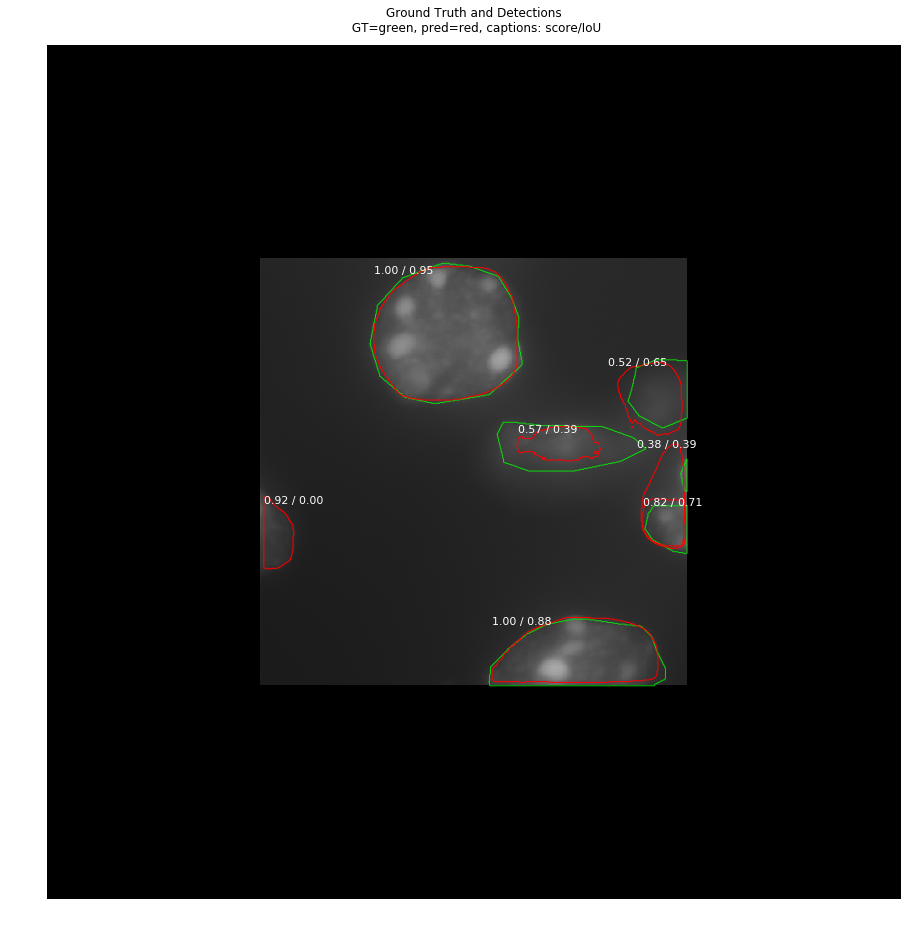

In [16]:
image_id = random.choice(nuclei_validation.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(nuclei_validation, config, image_id, use_mini_mask=False)
info = nuclei_validation.image_info[image_id]
# print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#                                        nuclei_validation.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    nuclei_validation.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

## Segment the remaining images

In [42]:
# Save data_name
file_segmented = 'segmented_result_T1_20181114.pkl'
results_dir = ROOT_DIR + '/results_segmentation/'

# Prepare seg dataset
seg_dir = ROOT_DIR + '/large_data_extracted/'
nuclei_seg = NucleiDataset()
nuclei_seg.add_segmentation_classes(labels_dict)
nuclei_seg.load_nuclei_validation(dataset_dir, seg_dir)
nuclei_seg.prepare()

In [18]:
# for multiple images
for image_id in nuclei_seg.image_ids:
    print(nuclei_seg.image_info[image_id]['id'])
    fname = nuclei_seg.image_info[image_id]['id'].split('.')[0]+'_seg_results.pkl'
    image = nuclei_seg.load_image_png(image_id)
    image_info = nuclei_seg.image_info[image_id]
    # Run object detection
    results = model.detect([image], verbose=1)
    pickle.dump(results,open(results_dir+fname,'wb'))


20181107_182739_066_Seq0004_2.png
Processing 1 images
image                    shape: (2048, 2048, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:  -47.22000  max:  215.44000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.36358  max:    1.30101  float32
20181107_182739_066_Seq0004_10.png
Processing 1 images
image                    shape: (2048, 2048, 3)       min:    1.00000  max:  193.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:  -47.22000  max:  150.44000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.36358  max:    1.30101  float32
20181107_182739_066_Seq0004_11.png
Processing 1 images
image                    shape: (2048, 2048, 3)       min:    4.00000  m

In [63]:
# for one image
image_id = nuclei_seg.image_ids[7]
print(nuclei_seg.image_info[image_id]['id'])
fname = nuclei_seg.image_info[image_id]['id'].split('.')[0]+'_seg_results.pkl'
image = nuclei_seg.load_image_png(image_id)
image_info = nuclei_seg.image_info[image_id]
# Run object detection
results = model.detect([image], verbose=1)
pickle.dump(results,open(results_dir+fname,'wb'))



Nuclei_SN_Hyb2_pos_231.png
Processing 1 images
image                    shape: (2048, 2048, 3)       min:   25.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:  -23.22000  max:  212.44000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.36358  max:    1.30101  float32


In [64]:
image_info = nuclei_seg.image_info[image_id]
image_path = image_info['path']
image = skimage.io.imread(image_path)
image = skimage.img_as_ubyte(image)
image = skimage.color.grey2rgb(image)

In [65]:
image.shape

(2048, 2048, 3)

In [66]:
image.dtype

dtype('uint8')

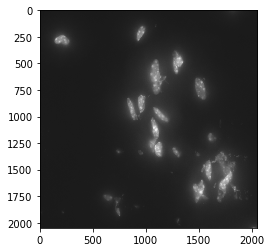

In [67]:
plt.figure()
plt.imshow(image)

[0.99939585 0.9968528  0.99134994 0.9776909  0.9736041  0.9613762
 0.872865   0.7781892  0.7598102  0.7221702  0.708438   0.66937715
 0.61830974 0.6132695  0.5969871  0.56466126 0.5096113  0.4760829 ]
7


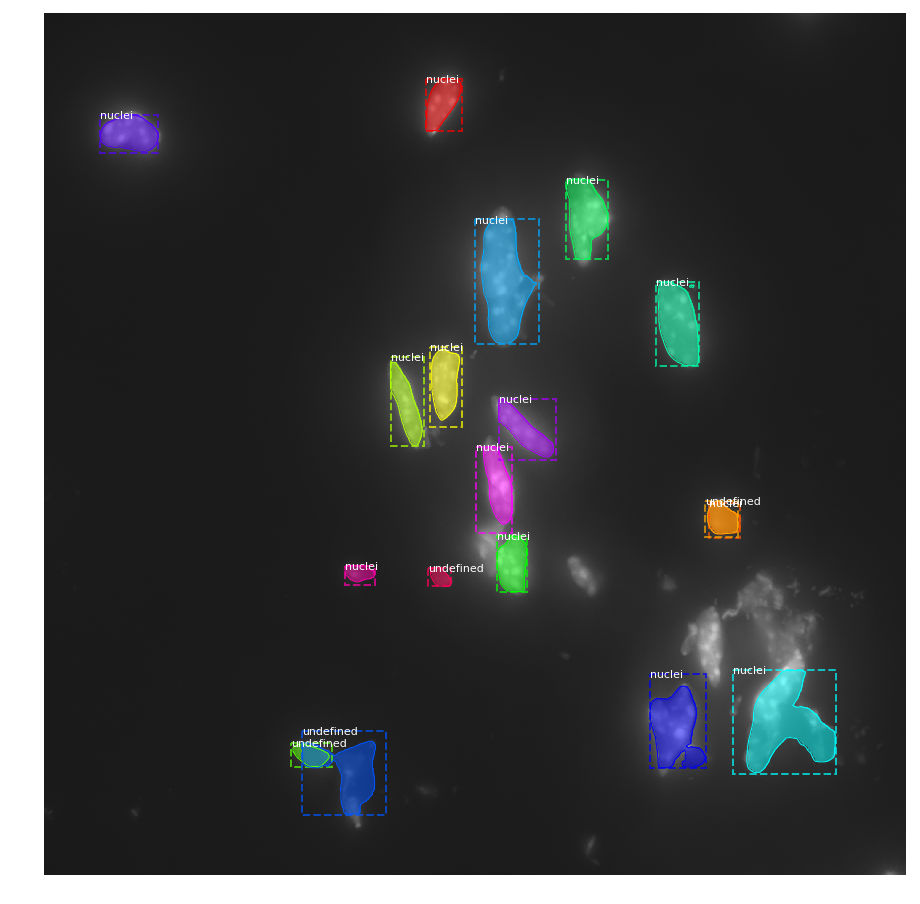

In [68]:
# # Display results
#image_id = random.choice(nuclei_seg.image_ids)
image_id = nuclei_seg.image_ids[7]
segfilename = nuclei_seg.image_info[image_id]['id'].split('.')[0]+'_seg_results.pkl'
image = nuclei_seg.load_image_png(image_id)
results = pickle.load(open(results_dir+segfilename,'rb'))
r = results[0]

visualize.display_instances(
    image,
    r['rois'], r['masks'], r['class_ids'], nuclei_seg.class_names,
    ax=get_ax(),
    show_bbox=True, show_mask=True)
print(r['scores'])
print(image_id)

In [27]:
type(results)

list

In [28]:
a=results[0]
a.keys()

dict_keys(['rois', 'class_ids', 'scores', 'masks'])

In [30]:
r['scores']

array([0.9987657 , 0.9983473 , 0.997168  , 0.9970469 , 0.9968035 ,
       0.9960328 , 0.9959955 , 0.99574655, 0.9942069 , 0.99227834,
       0.99207485, 0.9916539 , 0.9913941 , 0.9913771 , 0.989405  ,
       0.98659027, 0.97961116, 0.96743685, 0.9643935 , 0.96239716,
       0.95681024, 0.9549662 , 0.95493096, 0.9289428 , 0.9229887 ,
       0.9203558 , 0.900213  , 0.85665584, 0.84124225, 0.83245164,
       0.66582835, 0.66359454, 0.62290716, 0.51511425, 0.34223405],
      dtype=float32)